In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from maddpg import MADDPG

from unityagents import UnityEnvironment

In [2]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


In [5]:
# MA-DDPG initialization 
agent = MADDPG(num_agents=num_agents, state_size=env_info.vector_observations.shape[1], action_size=brain.vector_action_space_size, random_seed=40)

In [6]:
n_episodes = 3000
max_t = 1000
save_episodes = 500
scores_deque = deque(maxlen=100)
scores = []
avg_scores = []

print_every = 100
start_time = time.time()

for i_episode in range(1, n_episodes+1):
    
    agent.reset()                                          # reset agent 
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    score = np.zeros(num_agents)                          # initialize the score (for each agent)
    
    for t in range(max_t):

        actions = agent.act(states)
        actions = np.clip(actions, -1, 1) 

        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished        
        score += env_info.rewards                         # update the score (for each agent)
        
        agent.step(states, actions, rewards, next_states, dones)
        states = next_states                               # roll over states to next time step
        
        if np.any(dones):
            break 
    
    # max score of 2 agents
    score = np.max(score)
    scores_deque.append(score)
    scores.append(score)
    avg_scores.append(np.mean(scores_deque))
        
    if np.mean(scores_deque) >= 0.5:
        # the agent achieve average of 0.5 for 100 consecutive episodes
        actors_local = agent.get_actor_local() 
        for i,actor_local in enumerate(actors_local):
            torch.save(actor_local.state_dict(), 'checkpoint_actor_ma'+ str(i) +'.pth')
        critics_local = agent.get_critic_local()
        for i, critic_local in enumerate(critics_local):
            torch.save(critic_local.state_dict(), 'checkpoint_critic_ma_'+ str(i) +'.pth')
        print('\rSolved on Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        break 
    
    if i_episode % print_every == 0:
        # training time
        end_time = time.time()
        total_train_time = end_time - start_time
        start_time = time.time()
        
        print('\rEpisode {}\tAverage Score: {:.2f} \tMax Score: {:.2f} \tScore: {:.2f} \tTime: {} \tT: {}'.format(i_episode, 
                                                                                     np.mean(scores_deque),
                                                                                     np.max(scores_deque),                     
                                                                                     score, 
                                                                                     datetime.timedelta(seconds=int(total_train_time)),
                                                                                                                 t))#, end="")

    if i_episode % save_episodes == 0:
        actors_local = agent.get_actor_local() 
        for i,actor_local in enumerate(actors_local):
            torch.save(actor_local.state_dict(), 'checkpoint_actor_ma'+ str(i) +'.pth')
        critics_local = agent.get_critic_local()
        for i, critic_local in enumerate(critics_local):
            torch.save(critic_local.state_dict(), 'checkpoint_critic_ma_'+ str(i) +'.pth')
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   

Episode 100	Average Score: 0.01 	Max Score: 0.10 	Score: 0.00 	Time: 0:00:44 	T: 13
Episode 200	Average Score: 0.00 	Max Score: 0.10 	Score: 0.00 	Time: 0:00:48 	T: 15
Episode 300	Average Score: 0.01 	Max Score: 0.10 	Score: 0.00 	Time: 0:00:59 	T: 13
Episode 400	Average Score: 0.04 	Max Score: 0.10 	Score: 0.10 	Time: 0:01:16 	T: 51
Episode 500	Average Score: 0.04 	Max Score: 0.10 	Score: 0.00 	Time: 0:01:12 	T: 13
Episode 500	Average Score: 0.04
Episode 600	Average Score: 0.05 	Max Score: 0.20 	Score: 0.10 	Time: 0:01:17 	T: 30
Episode 700	Average Score: 0.06 	Max Score: 0.20 	Score: 0.10 	Time: 0:01:25 	T: 30
Episode 800	Average Score: 0.05 	Max Score: 0.10 	Score: 0.00 	Time: 0:01:12 	T: 13
Episode 900	Average Score: 0.05 	Max Score: 0.20 	Score: 0.10 	Time: 0:01:21 	T: 32
Episode 1000	Average Score: 0.09 	Max Score: 0.50 	Score: 0.10 	Time: 0:02:00 	T: 48
Episode 1000	Average Score: 0.09
Episode 1100	Average Score: 0.10 	Max Score: 0.30 	Score: 0.10 	Time: 0:02:09 	T: 51
Episode 1

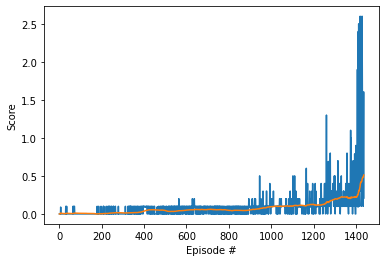

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
env.close()

In [10]:
agent.maddpg_agent[0].actor_local

Actor(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [11]:
agent.maddpg_agent[0].critic_local

Critic(
  (fcs1): Linear(in_features=48, out_features=64, bias=True)
  (fc2): Linear(in_features=68, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [12]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
